In [47]:
import random
import keras
import keras_metrics
import subprocess
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from keras.layers import Dense, Embedding
from keras.layers import LSTM
from keras.models import Sequential
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import word_tokenize

from sklearn.metrics import roc_curve, roc_auc_score, auc

tokenizer = Tokenizer()

In [2]:
def extract_stems(line):
    tokens = word_tokenize(line)
    stop_words = set(stopwords.words('english'))
    tokens = [w for w in tokens if w not in stop_words]
    porter = PorterStemmer()
    stems = []
    for t in tokens:
        stems.append(porter.stem(t))
    return stems

In [3]:
def get_one_hot(stems, vocab):
    seq = []
    for stem in stems:
        if stem in vocab:
            seq.append(vocab[stem] - 1)
    return seq

In [4]:
def load_vocab():
    with open('vocab.pickle', 'rb') as f:
        vocab = pickle.load(f)
        return vocab

In [5]:
class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, vocab, maxlen, bot_file_name='trv-bot.txt', gen_file_name='trv-gen.txt', batch_size=64):
        'Initialization'
        self.bot_file_name = bot_file_name
        self.gen_file_name = gen_file_name
        self.vocab = vocab
        self.maxlen = maxlen
        self.size = int(subprocess.check_output(['wc', '-l', bot_file_name]).split()[0]) * 2
        self.batch_size = batch_size
        self.bot_file = open(self.bot_file_name, 'r', errors='ignore')
        self.gen_file = open(self.gen_file_name, 'r', errors='ignore')
        self.on_epoch_end()

    def on_epoch_end(self):
        self.bot_file = open(self.bot_file_name, 'r', errors='ignore')
        self.gen_file = open(self.gen_file_name, 'r', errors='ignore')

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(self.size / self.batch_size)

    def __getitem__(self, index):
        'Generate one batch of data'
        bot_data = []
        for _ in range(int(self.batch_size / 2)):
            bot_data.append(self.bot_file.readline())
        gen_data = []
        for _ in range(int(self.batch_size / 2)):
            gen_data.append(self.gen_file.readline())

        x_data = []
        for line in bot_data:
            stems = extract_stems(line)
            x_data.append(get_one_hot(stems, vocab))
        for line in gen_data:
            stems = extract_stems(line)
            x_data.append(get_one_hot(stems, vocab))
        y_data = [1] * len(bot_data) + [0] * len(gen_data)

        train_set = list(zip(x_data, y_data))
        random.shuffle(train_set)
        x, y = zip(*train_set)
        x = sequence.pad_sequences(np.array(x), maxlen=self.maxlen)
        return x, np.array(y)

In [6]:
def get_test_data(maxlen):
    with open('test-bot.txt', 'r', errors='ignore') as file:
        bot_data = file.readlines()

    with open('test-gen.txt', 'r', errors='ignore') as file:
        gen_data = file.readlines()

    x_data = []
    for line in bot_data:
        stems = extract_stems(line)
        x_data.append(get_one_hot(stems, vocab))
    for line in gen_data:
        stems = extract_stems(line)
        x_data.append(get_one_hot(stems, vocab))
    y_data = [1] * len(bot_data) + [0] * len(gen_data)
    
    x = sequence.pad_sequences(np.array(x_data), maxlen=maxlen)
    return x, np.array(y_data)

In [35]:
max_features = 10000
maxlen = 32
batch_size = 256
vocab = load_vocab()
print('vocab size:', len(vocab))

vocab size: 10000


In [36]:
training_generator = DataGenerator(vocab, maxlen, 'train-bot.txt', 'train-gen.txt', batch_size)
validation_generator = DataGenerator(vocab, maxlen, 'validation-bot.txt', 'validation-gen.txt', batch_size)

In [37]:
model = Sequential()
model.add(Embedding(len(vocab), 128))
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy',keras_metrics.precision(), keras_metrics.recall()])

In [38]:
history = model.fit_generator(generator=training_generator,
                    validation_data=validation_generator,
                    epochs=20)

Epoch 1/20
1875/1875 [==============================] - 186s 99ms/step - loss: 0.2639 - acc: 0.8881 - precision: 0.9264 - recall: 0.8432 - val_loss: 0.2243 - val_acc: 0.9052 - val_precision: 0.9488 - val_recall: 0.8567
Epoch 2/20
1875/1875 [==============================] - 188s 100ms/step - loss: 0.2064 - acc: 0.9135 - precision: 0.9448 - recall: 0.8784 - val_loss: 0.2105 - val_acc: 0.9130 - val_precision: 0.9524 - val_recall: 0.8694
Epoch 3/20
1875/1875 [==============================] - 187s 100ms/step - loss: 0.1869 - acc: 0.9222 - precision: 0.9484 - recall: 0.8929 - val_loss: 0.2099 - val_acc: 0.9165 - val_precision: 0.9414 - val_recall: 0.8883
Epoch 4/20
1875/1875 [==============================] - 187s 100ms/step - loss: 0.1737 - acc: 0.9273 - precision: 0.9501 - recall: 0.9021 - val_loss: 0.2103 - val_acc: 0.9177 - val_precision: 0.9400 - val_recall: 0.8925
Epoch 5/20
1875/1875 [==============================] - 187s 100ms/step - loss: 0.1620 - acc: 0.9325 - precision: 0.9532 

In [39]:
model.save_weights("lstm-c/model.h5")
print("Saved model to disk")

Saved model to disk


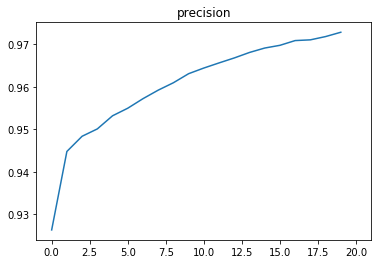

In [40]:
plt.xlim(left=-1, right=21)
plt.title('precision')
plt.plot(history.history['precision'], label='train')
plt.savefig('lstm-c/precision.svg')

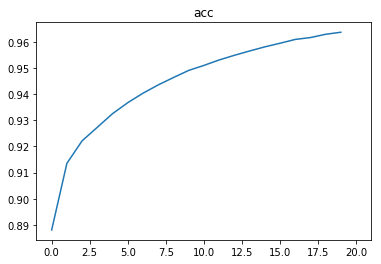

In [42]:
plt.xlim(left=-1, right=21)
plt.title('acc')
plt.plot(history.history['acc'], label='train')
plt.savefig('lstm-c/accuracy.svg')

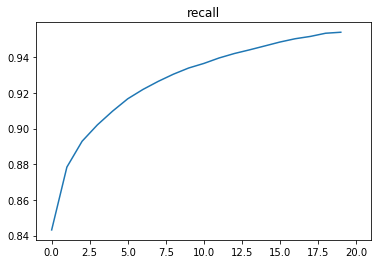

In [43]:
plt.xlim(left=-1, right=21)
plt.title('recall')
plt.plot(history.history['recall'], label='train')
plt.savefig('lstm-c/recall.svg')

In [45]:
x_test, y_test = get_test_data(maxlen)

In [48]:
y_pred = model.predict(x_test).ravel()
fpr, tpr, threshold = roc_curve(y_test, y_pred)

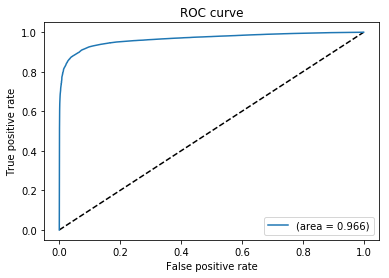

In [49]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='(area = {:.3f})'.format(auc(fpr, tpr)))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.savefig('lstm-c/roc.svg')

In [50]:
score, acc, p, r = model.evaluate(x_test, y_test,
                           batch_size=batch_size)
print('score:', score)
print('accuracy:', acc)
print('precision:', p)
print('recall:', r)

159998/159998 [==============================] - 3s 21us/step
score: 0.3362360287945584
accuracy: 0.9183364792477139
precision: 0.9260579518244563
recall: 0.9092727318171588
